#   ПРОЕКТ: Сравнение потребительского поведения пользователей фирмы GoFast c подписке и с бесплатной версией

### Описание проекта: 

В ходе проекты необходимо:
1. Осуществить проверку распределения данных и провести необходимые преобразования с ними для дальнейшего анализа
2. Провести исследовательский анализ данных, построить графики по количеству городов, возрастов, длин и продолжительностей поездок и видов подписки в выборке 
3. Подсчитать среднюю выручку от каждого пользователя по каждому месяцу
4. Статистически проверить исследовательские гипотезы:

      **1) Среднее время поездок пользователей с подпиской больше времени поездок пользователей без нее**
      
      **2) Пользователи с подпиской проезжают меньше 3130 м.**
      
      **3) Пользователи с подпиской в среднем платят больше, чем пользователи без нее**
5. С помощью апроксимации распределений найти вероятность того, что уведомление откроют не более 399,5 тыс (при рассылке в 1.1 млн)
       


### Цель проекта: 

Составить модели пользователького поведения клиентов GoFats и убедиться, что пользователи с подпиской выгоднее для компании в целях увелечения прибыли 


### Набор данных

**Пользователи — users_go.csv**

| Поле | Описание |
|------|----------|
| *user_id* | Уникальный идентификатор пользователя |
| *name* | Имя пользователя |
| *age* | Возраст |
| *city* | Город |
| *subscription_type* | Тип подписки (free, ultra) |

**Поездки — rides_go.csv**

| Поле | Описание |
|------|----------|
| user_id | Уникальный идентификатор пользователя |
| *distance* | Расстояние, которое пользователь проехал в текущей сессии (в метрах) |
| *duration* | Продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку "Начать поездку" до момента, как он нажал кнопку "Завершить поездку" |
| *date* | Дата совершения поездки |

**Подписки — subscriptions_go.csv**

| Поле | Описание |
|------|----------|
| *subscription_type* | Тип подписки |
| *minute_price* | Стоимость одной минуты поездки по данной подписке |
| *start_ride_price* | Стоимость начала поездки |
| *subscription_fee* | Стоимость ежемесячного платежа |



### Импорт библиотек 

In [79]:
#Импортируем библиотеки
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats as st
from scipy.stats import binom
from scipy.stats import norm
from math import sqrt

### Загрузка данных

In [13]:
#Считываем данные их файлов
users = pd.read_csv("users_go.csv")
rides = pd.read_csv("rides_go.csv")
sub = pd.read_csv("subscriptions_go.csv")

In [14]:
#Необходимоя информация по каждому датафрейму
for df in [users, rides, sub]:
    print(df.head())
    print("")
    print(df.info())
    print("____________________________________________________________________")

   user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None
____________________________________________________________________
   user_id     distance   duration        date
0        1  4409.919

##### Проверка распределения имеющихся значений 

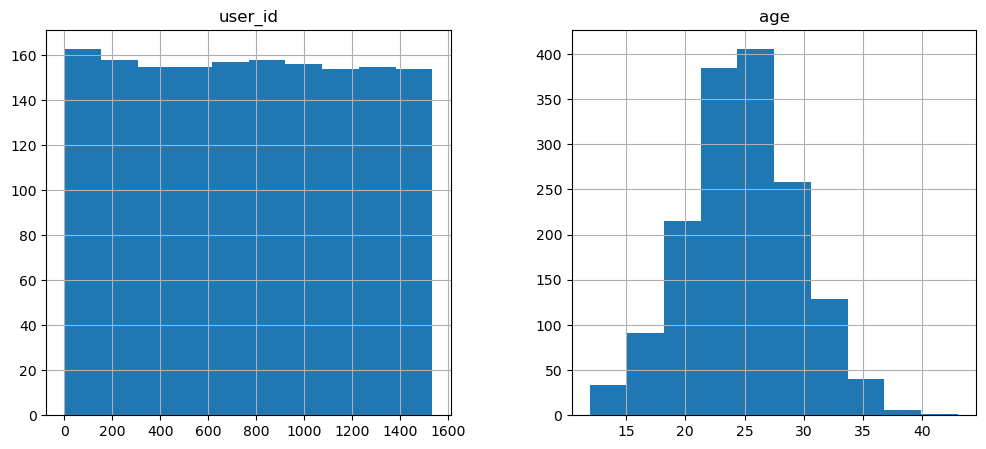

In [15]:
#Выведем диаграммы, чтобы посмотреть, как ведут себя превоначальные данные
users.hist(figsize = (12, 5))
plt.show()

В целом все логично: id распределены равномерно, возрасты нормально, как и должно быть

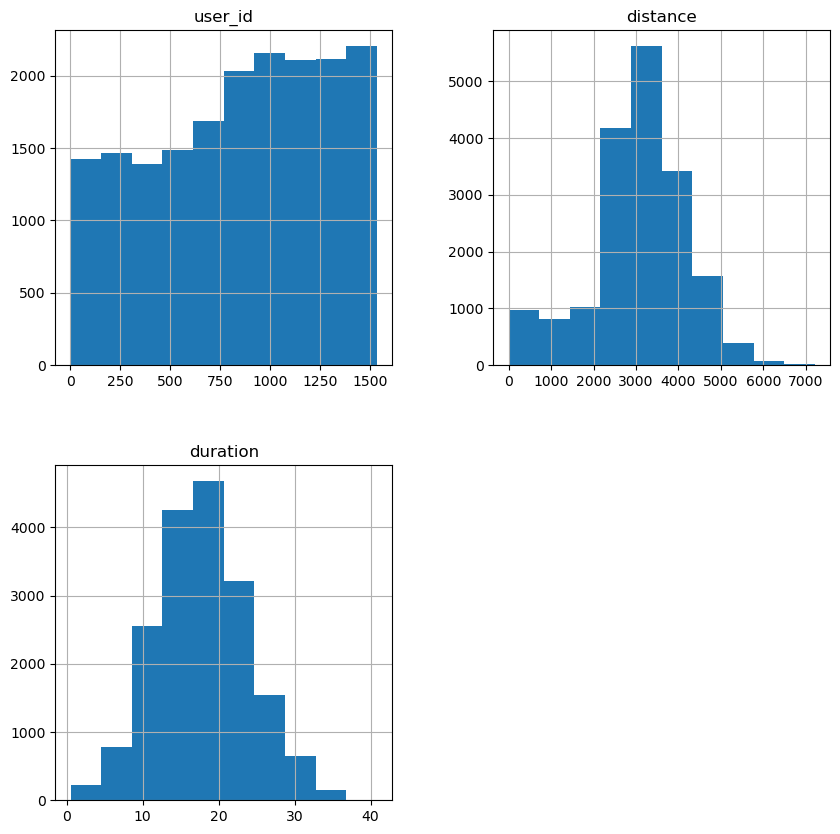

In [16]:
#Выведем диаграммы, чтобы посмотреть, как ведут себя превоначальные данные
rides.hist(figsize = (10, 10))
plt.show()

Аналогично как и в прошлом наборе данных: id распределены почи равномерно (понятно, что какие-то пользователи катались больше, какие-то меньше), дистанция и продолжительность - нормально. 

Итак, по графикам мы видим, что там, где данные являются количественным, распределение в целом соответствует ожиданию. Данные пригодны для дальнейшей аналитической работы

### Предобработка данных

#### 1. Для данных с пользователями

Проверка на пропуски

In [52]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Проверка на дубликаты

In [54]:

users.duplicated().sum()

#уберем дубликаты
users = users.drop_duplicates()

#Подсчитаем количество
users["user_id"].count()

1534

Проверим, что дроп дуубликатов  сработал

In [56]:

users.duplicated().sum()

0

#### Для данных с поездками

Проверим таблицу с поездками на пропуски

In [20]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

Проверим таблицу с поездками на дубликаты

In [57]:
rides.duplicated().sum()

0

Заменим данные с дантой на специальный формат

In [58]:
#меняем тип данных
rides["date"] = pd.to_datetime(rides["date"])
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 635.3 KB


In [59]:
#добавим к таблице столбец с номером месяца, в котором совершена поездка
rides["month"] = rides["date"]. dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


### Исследовательский анализ данных

##### Часстота встречаемости городов

In [24]:
#создаем сгруппированную таблицу по пользователям и считаем частоту встречаемости городом
cities_rate = users.groupby("city").agg({"user_id":"count"})
#обнуляем индексы в столбцах
cities_rate = cities_rate.reset_index()
#меняем название столбцов
cities_rate.columns = ["city", "count"]

#добовляем столбец с долями
cities_rate["ratio"] = cities_rate["count"] / cities_rate["count"].sum()
#выведем описательную статистику
print(cities_rate.describe())
cities_rate

            count     ratio
count    8.000000  8.000000
mean   191.750000  0.125000
std     15.672998  0.010217
min    168.000000  0.109518
25%    182.250000  0.118807
50%    191.000000  0.124511
75%    199.500000  0.130052
max    219.000000  0.142764


,city,count,ratio
0,Екатеринбург,204,0.132986
1,Краснодар,193,0.125815
2,Москва,168,0.109518
3,Омск,183,0.119296
4,Пятигорск,219,0.142764
5,Ростов-на-Дону,198,0.129074
6,Сочи,189,0.123207
7,Тюмень,180,0.117340


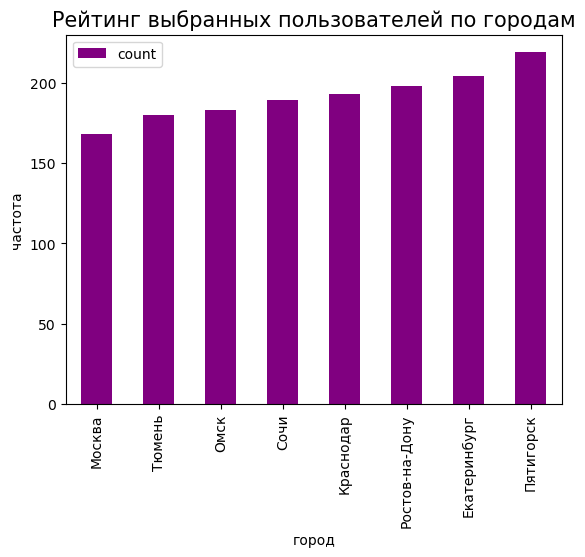

In [25]:
#Строим график по полученной таблице
ax = (
    cities_rate
    .sort_values(by = "count")
    .plot("city", kind="bar", y = "count", title = "Рейтинг выбранных пользователей по городам", color = "purple", ylabel="частота", xlabel="город")
)

ax.title.set_size(15)

##### Рейтинг пользователей с подпиской и без

In [60]:
#создаем сгруппированную таблицу по пользователям и считаем частоту (количество) пользователей с подпиской и без
subscribe_rate = users.groupby("subscription_type").agg({"user_id":"count"})
#обнуляем индексы в столбцах
subscribe_rate = subscribe_rate.reset_index()
#меняем название столбцов
subscribe_rate.columns = ["subscription", "count"]

#добовляем столбец с долями
subscribe_rate["ratio"] = subscribe_rate["count"] / subscribe_rate["count"].sum()

subscribe_rate

,subscription,count,ratio
0,free,835,0.544329
1,ultra,699,0.455671


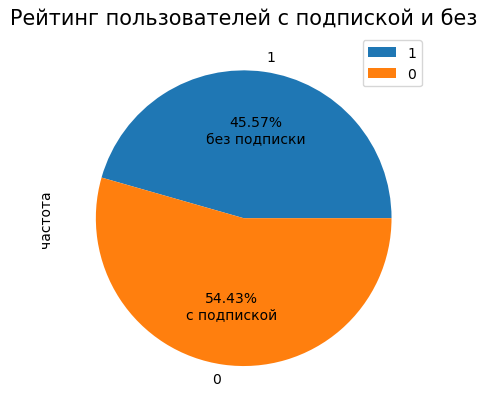

In [69]:
ax = (
    subscribe_rate
    .sort_values(by="count")
    .plot("subscription", kind="pie", y="count", title="Рейтинг пользователей с подпиской и без",
          xlabel="тип подписки", ylabel="частота",\
          autopct=lambda p : '{:.2f}%\n{}'.format(p, 'с подпиской' if int(p*10) % 2 == 0 else 'без подписки'))
)

ax.title.set_size(15)


##### Рейтинг пользователей по возрасту

In [28]:
#создаем сгруппированную таблицу по пользователям и считаем частоту пользователей всех встретившихся возростов
age_rate = users.groupby("age").agg({"user_id":"count"})
#обнуляем индексы в столбцах
age_rate = age_rate.reset_index()
#меняем название столбцов
age_rate.columns = ["age", "count"]


#добовляем столбец с долями
age_rate["ratio"] = age_rate["count"] / age_rate["count"].sum()
#выведем описательную статистику
print(age_rate.describe())
age_rate.head(10)

             age       count      ratio
count  29.000000   29.000000  29.000000
mean   26.103448   52.896552   0.034483
std     8.706914   48.824280   0.031828
min    12.000000    1.000000   0.000652
25%    19.000000    9.000000   0.005867
50%    26.000000   41.000000   0.026728
75%    33.000000   93.000000   0.060626
max    43.000000  145.000000   0.094524


,age,count,ratio
0,12,4,0.002608
1,13,8,0.005215
2,14,9,0.005867
3,15,13,0.008475
4,16,19,0.012386
5,17,26,0.016949
6,18,46,0.029987
7,19,47,0.030639
8,20,71,0.046284
9,21,93,0.060626


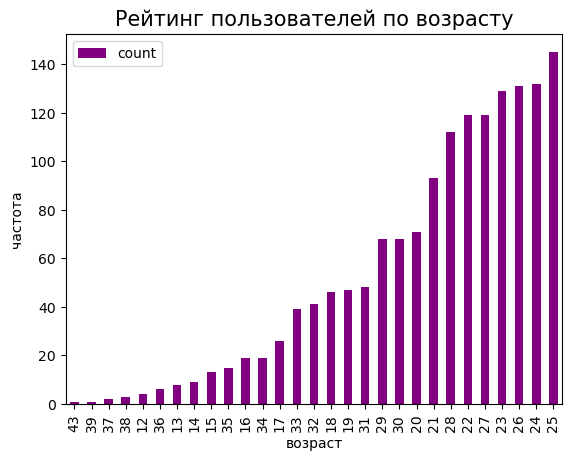

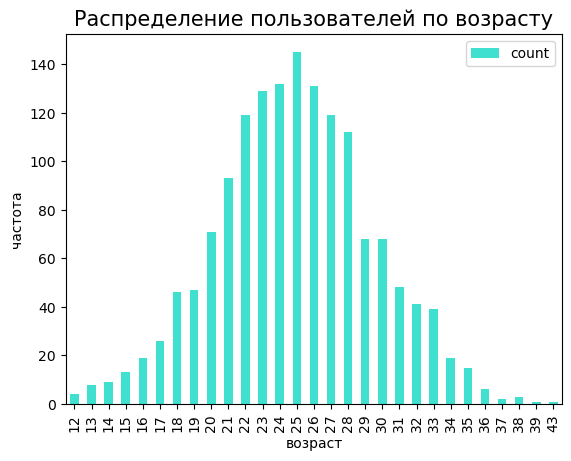

In [29]:
#По полученным данным строим график по рейтингу (возроста отсартированы по количеству)
ax = (
    age_rate
    .sort_values(by = "count")
    .plot("age", kind="bar", y = "count", title = "Рейтинг пользователей по возрасту", color = "purple", ylabel="частота", xlabel="возраст")
)

ax.title.set_size(15)

#А также график  с распределением (отображающий распределение данных без сортировки)
ax = (
    age_rate
    .plot("age", kind="bar", y = "count", title = "Распределение пользователей по возрасту", color = "turquoise", ylabel="частота", xlabel="возраст")
)

ax.title.set_size(15)

По возрасту пользователи распределены нормально

##### Распределение поездок по дистанции

In [30]:
#создаем сгруппированную таблицу по поездкам и считаем частоту всех дистанцийв
distance_rate = rides.groupby("distance").agg({"user_id":"count"})

#убираем индексы в столбцах
distance_rate = distance_rate.reset_index()
#меняем названия столбцов
distance_rate.columns = ["distance", "count"]

#добовляем доли
distance_rate["ratio"] = distance_rate["count"] / distance_rate["count"].sum()
#выведем описательную статистику
print(distance_rate.describe())

distance_rate.head(10)

           distance    count         ratio
count  18068.000000  18068.0  1.806800e+04
mean    3070.659976      1.0  5.534647e-05
std     1116.831209      0.0  1.155385e-17
min        0.855683      1.0  5.534647e-05
25%     2543.226360      1.0  5.534647e-05
50%     3133.609994      1.0  5.534647e-05
75%     3776.222735      1.0  5.534647e-05
max     7211.007745      1.0  5.534647e-05


,distance,count,ratio
0,0.855683,1,0.000055
1,2.570787,1,0.000055
2,4.329506,1,0.000055
3,6.784447,1,0.000055
4,7.097072,1,0.000055
5,11.283615,1,0.000055
6,12.233115,1,0.000055
7,15.000606,1,0.000055
8,15.366168,1,0.000055
9,15.630873,1,0.000055


Все наблюдаемые данные уникальны и представлены в большом количестве по отдельности, поэтому вместо стольчатой диаграммы, которая не способна отобразить данное распределение, построим гистограмму.

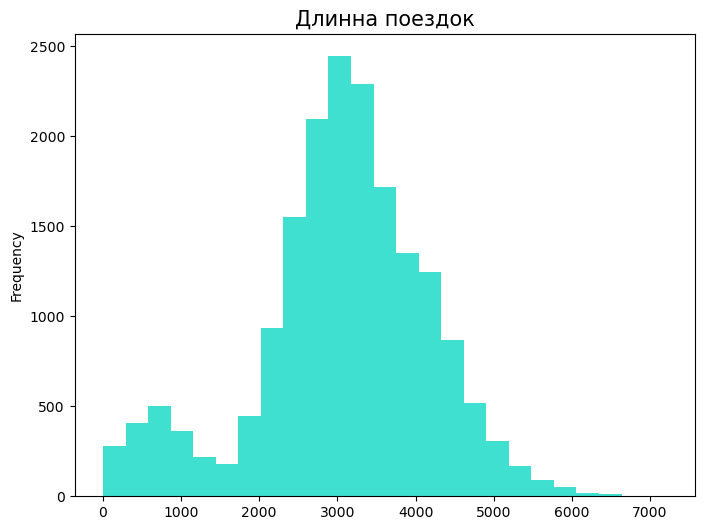

In [31]:
#сторим гистограмму по полученным данным
ax1 = (
    distance_rate["distance"]
    .plot(kind="hist", title = "Длинна поездок", color = "turquoise", bins=25, figsize=(8,6))
)

ax1.title.set_size(15)

##### Распределение поездок по длительности

In [32]:
#создаем сгруппированную таблицу по поездкам и считаем частоту всех длительностей поездок
duration_rate = rides.groupby("duration").agg({"user_id":"count"})

#убираем индексы в столбцах
duration_rate = duration_rate.reset_index()
#меняем названия столбцов
duration_rate.columns = ["duration", "count"]

#добавляем доли
duration_rate["ratio"] = duration_rate["count"] / duration_rate["count"].sum()

#выведем описательную статистику
print(duration_rate.describe())
duration_rate.sort_values(by="count", ascending=False).head(10)

           duration         count         ratio
count  17974.000000  17974.000000  17974.000000
mean      17.895513      1.005230      0.000056
std        5.976666      0.701141      0.000039
min        0.500000      1.000000      0.000055
25%       13.669653      1.000000      0.000055
50%       17.713710      1.000000      0.000055
75%       21.746921      1.000000      0.000055
max       40.823963     95.000000      0.005258


,duration,count,ratio
0,0.500000,95,0.005258
11980,20.293612,1,0.000055
11986,20.300855,1,0.000055
11985,20.300191,1,0.000055
11984,20.299309,1,0.000055
11983,20.295583,1,0.000055
11982,20.294795,1,0.000055
11981,20.294337,1,0.000055
11979,20.293365,1,0.000055
11988,20.301611,1,0.000055


In [33]:
#Наблюдатся выброс в количестве 95 знаений с продолжительностью поездки пол минуты. Посмотрим какая у них длительность
rides.loc[rides["duration"] == 0.500000]

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


В данном распределении наблюдается выброс по количесвту продолжительностей поездок, равных 0.5 минуты. По таблице выше  можно заметить, что за это время в среднем проезжают около 5км, что невозможНО фищически. Возможно ошибка в данных - количество незначительно, так что просто удалим их.

In [34]:
duration_rate = duration_rate.drop(duration_rate.loc[duration_rate["duration"] == 0.500000].index)
duration_rate.head()

,duration,count,ratio
1,2.035632,1,0.000055
2,2.053251,1,0.000055
3,2.180879,1,0.000055
4,2.222598,1,0.000055
5,2.224797,1,0.000055


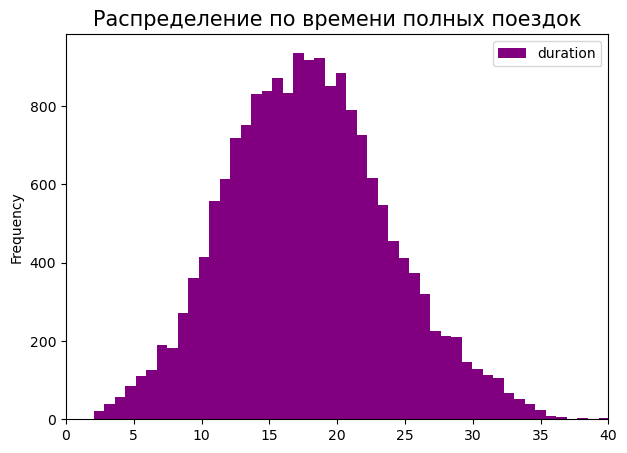

In [70]:
#строим второй график, исключая выброс в начале
ax = (
    duration_rate
    .query("count != 95")
    .plot(kind="hist", y="duration", title = "Распределение по времени полных поездок", color = "purple", figsize=(7,5), xlim=(0,40), bins=50)
)
ax.title.set_size(15)

- В целом, 95 оборванных поездок практически не заметны на фоне общего числа
- Распределения длин поездок нормальны

Итак, на данном этапе проектной работы удалось провести исследовательский анализ, который позвовил получить  следующие результаты, и представить их на графиках
      
      Состать рейтинг по полулярности городов в выборке пользователей: самый менее популярный - Москва, наиболее популярный - Пятигорск
      
      Сравнить рейтинг количества пользователей с подпиской и без: пользователей с подпиской меньше примерно на 150 человек
      
      Состать рейтинг по возростам: возроста пользователей в выборке распределены нормально со средним в 25 лет.
      
      Представить распределение по длинее поездок: все длины уникальны и распределены нормально со средним в 3070 м.
      
      Представить распределение по длительности поездок: все длины уникальны (кроме выброса с 95ю оборвавшимися поездками) и распределены нормально со средним в 18 минут

#### Шаг 4. Объединение данных

In [36]:
#объединяем 1 и 2 датафрейм
rides_users = rides.merge(users)
#2  и 3й
full_data = rides_users.merge(sub)

#получаем общую таблицу со всеми данными
full_data.head()

#print(full_data.info())

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Видим по информации, что в таблице после объединения не появилось пропусков и количество данных соответствкет ожидаемому

In [37]:
#сохраним также отдельно таблицы со всеми пользователями с подпиской и без
frees = full_data.query("subscription_type == 'free'")
discribes = full_data.query("subscription_type != 'free'")

Итак, удалось необходимым образом совместить таблицы между собой, для получения новых данных в ходе дальнейших действий

#### Шаг 5. Подсчёт выручки|

In [38]:
#Округлим необходимые значения

full_data["duration"] = np.ceil(full_data["duration"])

In [39]:
#создаем сгруппированную таблицу по пользователям и месяцам и считаем суммы продолжительностей и дистанций поездок, а также число поездок, совершенных пользователем
agr = full_data.groupby(["user_id", "month"]).agg({"distance":"sum", "duration":"sum", "city":"count"}).reset_index()

#переиминовываем столбцы
agr.columns = ['user_id', 'month', 'distance', 'duration', 'count']
agr.head(10)

,user_id,month,distance,duration,count
0,1,1,7027.511294,42.0,2
1,1,4,754.159807,7.0,1
2,1,8,6723.470560,46.0,2
3,1,10,5809.911100,32.0,2
4,1,11,7003.499363,56.0,3
5,1,12,6751.629942,28.0,2
6,2,3,10187.723006,63.0,3
7,2,4,6164.381824,40.0,2
8,2,6,3255.338202,14.0,1
9,2,7,6780.722964,48.0,2


In [40]:
#в эту же таблицу добавим данные по подписке
agr = agr.merge(users[["user_id", "subscription_type"]], on="user_id")
agr

,user_id,month,distance,duration,count,subscription_type
0,1,1,7027.511294,42.0,2,ultra
1,1,4,754.159807,7.0,1,ultra
2,1,8,6723.470560,46.0,2,ultra
3,1,10,5809.911100,32.0,2,ultra
4,1,11,7003.499363,56.0,3,ultra
...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2,free
11327,1534,8,7622.453034,48.0,2,free
11328,1534,9,4928.173852,23.0,1,free
11329,1534,11,13350.015305,78.0,4,free


In [41]:
#выведем фиксированные значения
minute_price_free = sub.loc[0, "minute_price"]
minute_price_ultra = sub.loc[1, "minute_price"] 
start_free = sub.loc[0, "start_ride_price"]
ultra_price = sub.loc[1, "subscription_fee"]


#добавим пустой столбец и заполним его исходя из условий поездок
agr["income"] = 0
#если подписка не активна то выручка равна длине поездки умноженной на тариф + число поездок умноженное на стартовый прайс
agr.loc[agr["subscription_type"] == "free", "income"] = agr["duration"] * minute_price_free + start_free*agr["count"]
#если подписка активна, то выручка равна цене подписки за месяц + длина поездки умноженная на тариф по подписке
agr.loc[agr["subscription_type"] == "ultra", "income"] = agr["duration"] * minute_price_ultra + ultra_price
agr.head()

,user_id,month,distance,duration,count,subscription_type,income
0,1,1,7027.511294,42.0,2,ultra,451
1,1,4,754.159807,7.0,1,ultra,241
2,1,8,6723.470560,46.0,2,ultra,475
3,1,10,5809.911100,32.0,2,ultra,391
4,1,11,7003.499363,56.0,3,ultra,535


Таким образом, проведенные операции с таблицами, позволили необходимым образом совместить имеющиеся данные и подсчитать информацию о средней выручке от всех пользователей по всем месецам, на основе чего будет проверена одна из гипотез

#### Шаг 6. Проверка гипотез

<strong> В рамках данного шага необходимо проверить следующие поставленные гипотезы: </strong>
    
    время поездок пользователей с подпиской больше, чем время поездок пользователей без нее
    
    пользователи с подпиской проезжают в среднем за поездку меньше 3130 м.
    
    пользователи с подпиской платят за месяц больше, чем пользователи без.
    
    после обновления мобильного приложения, количество обращений в поддержку уменьшилось
    
    
    

In [42]:
#Подготавливаем наборы данных для сравнения 

#продолжительность с подпиской и без
duration_free = full_data.query("subscription_type == 'free'")["duration"]
duration_ultra = full_data.query("subscription_type == 'ultra'")["duration"]

distance_ultra = full_data.query("subscription_type == 'ultra'")["distance"]

#выручка с подпиской и без
income_free = agr.query("subscription_type == 'free'")["income"]
income_ultra = agr.query("subscription_type == 'ultra'")["income"]

duration_ultra

0       26.0
1       16.0
2        7.0
3       19.0
4       27.0
        ... 
6495    25.0
6496    16.0
6497    15.0
6498    16.0
6499    26.0
Name: duration, Length: 6500, dtype: float64

##### Вреемя поездок пользователей с подпиской и без

- Нулевая гипотеза: время поездок пользователей с подпиской и без равны
- Альтернативная гипотеза: время поездок пользователей с подпиской больше, чем время поездок пользователей без нее

In [43]:
#устанавливаем уровень значимости
alpha = 0.01

#Делаем двувыборочный t-test для двух независимых выборок, с односторонней альтернативной гипотезой (среднее по 1й группе > среднего по 2й)
result = st.ttest_ind(duration_ultra, duration_free, alternative='greater')

#На основе сравнения p-значения с выбранным уровнем стат-значимости делаем выводы о состоянии H0:
if result.pvalue < alpha:
    print("Нулевая гипотеза отвергается")
else:
    print("Нулевая гипоьеза не отвергается")
    
print(f"значение pvalue: {result.pvalue}")

Нулевая гипотеза отвергается
значение pvalue: 2.4959453720736625e-34


Результат показывает, что среднее по первой группе (duration_ultra) значительно отличается от среднего второй группы (duration_free) на уровне значимости 0.01. Вероятность получить наблюдаемое различее случано - очень мала


Нулевая гипотеза отвергается в пользу альтернаитивной: <strong> среднее время поездок пользователей с подпиской больше времени поездок пользователей без нее </strong>

##### Дистанция поездки пользователей с подпиской

- Нулевая гипотеза: пользователи с подпиской проезжают за поездку 3130 м.
- Альтернативная гипотеза: пользователи с подпиской проезжают за поездку меньше 3130 м.

In [44]:
optimal = 3130

#устанавливаем уровень значимости
alpha = 0.01

#Делаем двувыборочный t-test для двух независимых выборок, с односторонней альтернативной гипотезой (среднее по 1й группе > среднего по 2й)
result = st.ttest_1samp(distance_ultra, optimal, alternative='less')

#На основе сравнения p-значения с выбранным уровнем стат-значимости делаем выводы о состоянии H0:
if result.pvalue < alpha:
    print("Нулевая гипотеза отвергается")
else:
    print("Нулевая гипоьеза не отвергается")
    
print(f"значение pvalue: {result.pvalue}")

Нулевая гипоьеза не отвергается
значение pvalue: 0.08046311521502146


С верояьностью, превышающей уровень статистической значимости, наблюдаемой различие можно получить случайно

Нулевая гипотеза не отвергается, следовательно нельзя принять альтернативную, <strong>  так что нельзя сказать, что пользователи с подпиской проезжают меньше 3130 м. </strong>. Такой вывод можно бы было сделать на уровне стат значимости 0.09, но это недостаточно достоверно

##### Выручка от пользователей с подпсикой и без

- Нулевая гипотеза: месячные выплаты пользователи с подпиской и без равны.
- Альтернативная гипотеза: пользователи с подпиской платят за месяц больше, чем пользователи без.

In [45]:
#устанавливаем уровень значимости
alpha = 0.01

#Делаем двувыборочный t-test для двух независимых выборок, с односторонней альтернативной гипотезой (среднее по 1й группе > среднего по 2й)
result = st.ttest_ind(income_ultra, income_free, alternative='greater')

#На основе сравнения p-значения с выбранным уровнем стат-значимости делаем выводы о состоянии H0:
if result.pvalue < alpha:
    print("Нулевая гипотеза отвергается")
else:
    print("Нулевая гипоьеза не отвергается")
    
print(f"значение pvalue: {result.pvalue}")

Нулевая гипотеза отвергается
значение pvalue: 1.8850394384715216e-31


Результат показывает, что среднее по первой группе (income_ultra) значительно отличается от среднего второй группы (income_free) на уровне значимости 0.01. Вероятность получить наблюдаемое различее случано - очень мала

Нулевая гипотеза отвергается, следовательно принимается альтернативная: <strong> пользователи с подпиской платят больше, чем пользователи без. </strong>

#### Количество обращений в поддержку до и после 

В данном случае для проверки изменения числа обращений в поддержку использовался бы тест для сравнения средних между зависимыми парными выборками: двубыборочный зависимый t-test с односторонней альтернативной гипотезей: поскольку речь идет об одной и той же генеральной совокупности, и соответсвенно выборке. Вопрос об изменении поведения одной и той же группы пользователей до введения изменений и после.

Если p-value по данному тесту не будет привышать уровня стат. значимости, то, отвергнув нулевую гипотезу о равенстве времен обращения, можно будет сказать, что число обращений после обновления уменьшилось

### Апроксимация распределения для оценки вероятности реакции пользователей на уведомления

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Уведомления открывают около 
40% получивших клиентов. Отдел планирует разослать 
1.1 млн уведомлений. 

Необходимо оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

**Подготовим данные и убедимся в том, что апроксимацию можно использвоать:**

In [82]:
#Найдем количество обращений 
n = 101
p = 0.1

miss_prob = 100


while miss_prob >= 5:
    distr = 0
    miss_prob = 0
    
    for k in range(0, 100):
        current_value = binom.pmf(k, n, p)
        distr += current_value

    miss_prob = distr*100
    n += 1

print(f'количество обращений {n-1}')

количество обращений 1161


In [83]:
#
n = 1161
p = 0.1
miss_prob = 0
distr = []
for k in range(n):
    value = binom.pmf(k, n, p)
    distr.append(value)
    
for i in range(100):
    miss_prob += distr[i]
print(f'Вероятность пропуска {miss_prob*100}')

Вероятность пропуска 4.976090094990326


In [84]:
n = 1000000
p = 0.4

treashold = 399500

mu = n*p
sigma = sqrt(n*p*(1-p))

if mu - 3*sigma > 0 and mu + 3*sigma < n:
    print("Aproximation allowded")
    

Aproximation allowded


Использование апроксимации допускается

In [90]:
#Задаем параметры 
n = 1000000
p = 0.4

treashold = 399500

mu = n*p
sigma = sqrt(n*p*(1-p))


distr = norm(mu, sigma)
result = distr.cdf(treashold - 1)
print(f'Оцениваемая вероятность: {result}') 

Оцениваемая вероятность: 0.15323384973591647


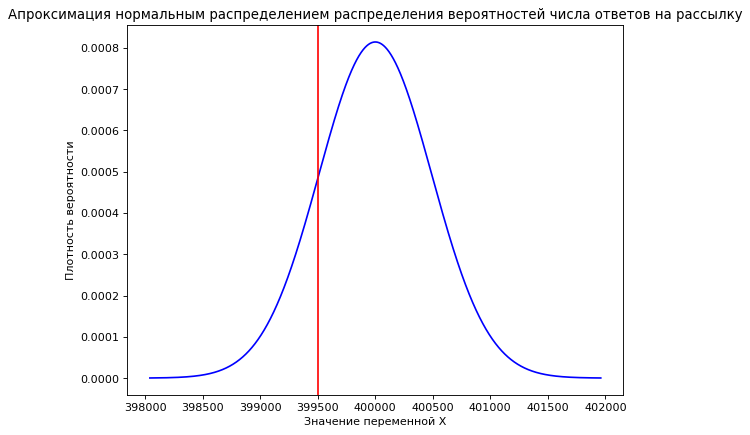

In [91]:
figure(figsize=(8, 6), dpi=80)
# x-axis ranges from -3 and 3 with .001 steps
arange = np.arange(
        (mu - 4 * sigma), 
        (mu + 4 * sigma), 
        0.001)

plt.plot(arange, st.norm.pdf(arange, mu, sigma), 'b-')
plt.axvline(x=399500, color='red')

# Добавляем названия осей
plt.xlabel('Значение переменной X')  # Название оси X
plt.ylabel('Плотность вероятности')  # Название оси Y

plt.title('Апроксимация нормальным распределением распределения вероятностей числа ответов на рассылку')
plt.show()


Таким образом, вероятность, что объявление откруют не более 399,5 тыс. пользователей довольно мала и равняется 15%

#### Выводы

В рамках текущего проекта был произведен спектр действий от превого знакомства данных до составления рейтингов и выводов о состоянии изучаемых явлений. В ходе работы удалось:

* Обработать и заменить пропуски в данных: 

      Избавиться от некоторых дубликатов 
    
      Добавить необходимый столбцы, нампример месяц совершения поездки
    
      Преобразовать типы данный

* Осуществить исследовательский анализ:

      Состать рейтинг по полулярности городов в выборке пользователей: самый менее популярный - Москва, наиболее популярный - Пятигорск
      
      Сравнить рейтинг количества пользователей с подпиской и без: пользователей с подпиской меньше примерно на 150 человек
      
      Состать рейтинг по возростам: возроста пользователей в выборке распределены нормально со средним в 25 лет.
      
      Представить распределение по длинее поездок: все длины уникальны и распределены нормально со средним в 3070 м.
      
      Представить распределение по длительности поездок: все длины уникальны (кроме выброса с 95ю оборвавшимися поездками) и распределены нормально со средним в 18 минут

* Преобразователь, сгруппировать таблицы и посчитать среднб выручку по пользователям и месецам

* На основе полученных данных, проверить поставленные гипотезы и получить следующие выводы:
         
      Среднее время поездок пользователей с подпиской больше времени поездок пользователей без нее
      
      Пользователи с подпиской проезжают меньше 3130 м.
      
      Пользователи с подпиской в среднем платят больше, чем пользователи без нее
      
*вероятность того, что уведомление откроют не более 399,5 тыс. пользователей - 15%*
       

Таким образом результате проделанных шагов, удалось получить представление о состоянии доходности в фирме GoFast от пользователей разных категорий, а также особенности их потребительского поведения      